#  How to create a Smoking Detection Application using AWS Panorama

**Use Case** : This can be used detect if a person is smoking at places where smoking is not permitted such as gas stations, schools

**Goal of this Notebook** :

* Aid an Panorama developer prototype their application before creating the AWS Lambda for Panorama
* Creating an MXNET application in the same structure as the AWS Lambda for Panorama
* Create and Deploy the AWS Lambda for Panorama from this notebook

**What this Notebook accomplishes?** :
* Detect Smoking using Kinetics 400 Model using MXNet
* Show the structure of the AWS Lambda for Panorama and replicate it using MXNet
* Create and publish the included AWS Lambda for Panorama directly to the AWS Lambda service



**Pre -Requisites**:
* Sagemaker Instance created with the right role (Policies needed IOT, Lambda and S3, IAM Full Access) ( Add Doc here)


**Frames to Process**:

* By default, we only process 10 frames from the video. If you want to increase this, please change this value in /panorama_sdk/panoramasdk.py and change frames_to_process = 10 to a value of your choice

#### Video to Use

In [1]:
video_to_use = "smoking.mp4"

####  1 Import Libraries

In [2]:
!pip3 install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


In [3]:
import cv2
import boto3
import json
from mxnet import nd
from gluoncv.model_zoo import get_model
import numpy as np
from gluoncv import utils
from IPython.display import Video
import matplotlib.pyplot as plt
from IPython.display import clear_output, Markdown, display

plt.rcParams["figure.figsize"] = (20,20)

In [4]:
def printmd(string, color=None):
    """
    Helper Function for Fomatting Output
    """
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

### 2. Code Walk Through

This step walks through using the MXNet model to get inference

**Model** : resnet101_v1b_kinetics400  
**Kinetics400** : This models is trained on [Kinetics400](https://deepmind.com/research/open-source/kinetics), a large-scale, high-quality dataset of URL links to approximately 650,000 video clips that covers 400 human action classes, including human-object interactions such as playing instruments, as well as human-human interactions such as shaking hands and hugging.   
**arXiv** :[The Kinetics Human Action Video Dataset](https://arxiv.org/abs/1705.06950)  
**Model Input Size** : 224 x 224  
**Model Output** : 400 Classes

##### **2.1. Loading the model**


In [5]:
action_detection_model_name = 'resnet101_v1b_kinetics400'
action_detection_model = get_model(action_detection_model_name, nclass=400, pretrained=True)

##### **2.2. Loading the video that we will do inference on**


In [6]:
inputs = 'smoking.mp4'

##### **2.3. Preprocessing function**


In [7]:
def preprocess(img, size):
    """
    # Performing transformations for the video clip / camera feed. This transformation function
    # does three things: center crop the image to 224x224 in size,
    # transpose it and normalize with
    # mean and standard deviation calculated across all frames.

    """
    resized = cv2.resize(img, (size, size))

    mean = [0.485, 0.456, 0.406]  # RGB
    std = [0.229, 0.224, 0.225]  # RGB

    img = resized.astype(np.float32) / 255.  # converting array of ints to floats
    img_a = img[:, :, 0]
    img_b = img[:, :, 1]
    img_c = img[:, :, 2]

    # Extracting single channels from 3 channel image
    # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)

    # normalizing per channel data:
    img_a = (img_a - mean[0]) / std[0]
    img_b = (img_b - mean[1]) / std[1]
    img_c = (img_c - mean[2]) / std[2]

    # putting the 3 channels back together:
    x1 = [[[], [], []]]
    x1[0][0] = img_a
    x1[0][1] = img_b
    x1[0][2] = img_c

    x1 = np.asarray(x1)
    return x1

##### 2.4. Using the model to do inference

The below example code does inference only on the first 180 frames. The code also visualizes the top 3 actions detected at each frame
  
**Note :** The actual / meaningful predictions start at around Frame 120

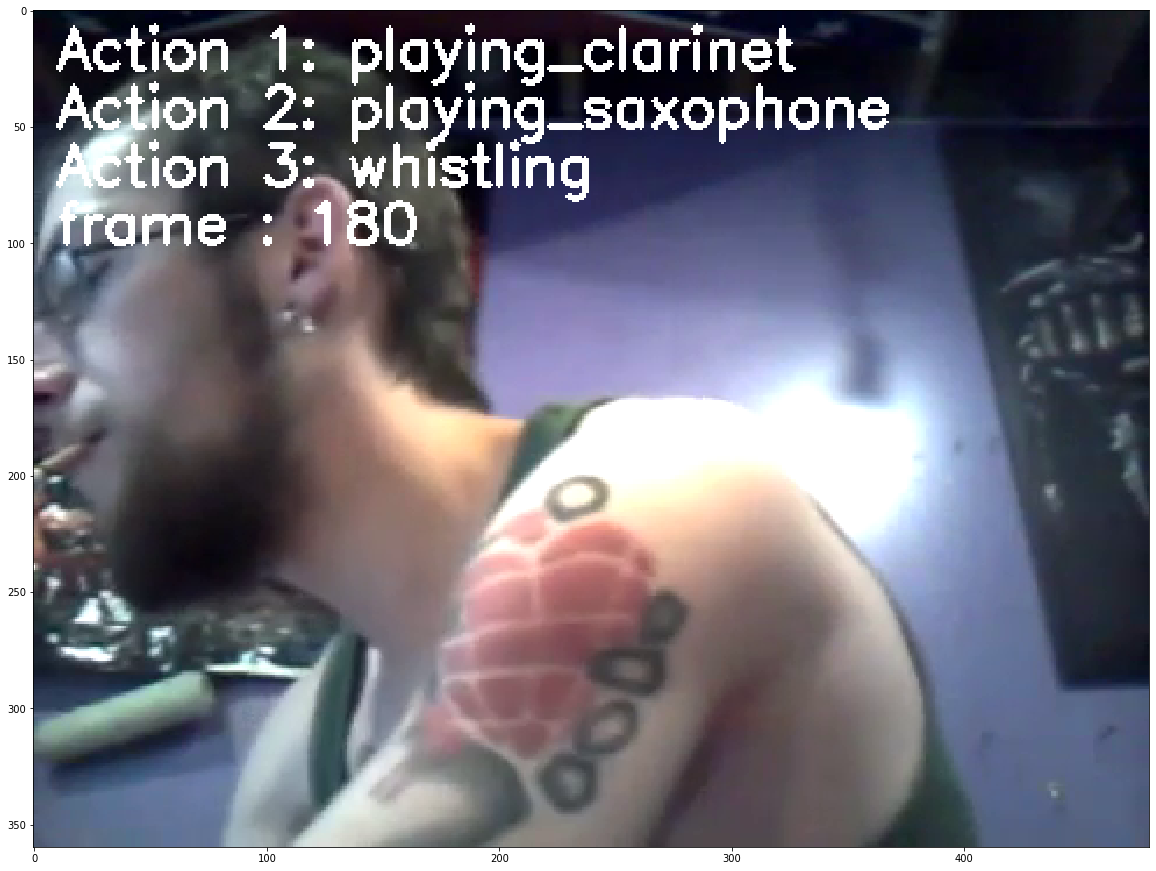

In [8]:
# Loading the video using opencv
cap = cv2.VideoCapture(inputs)
frame_number = 0
inference_on_number_of_frames = 180

# Looping thru the video
while(cap.isOpened()):
    
    # Increment Frame Number
    frame_number += 1
    
    (grabbed, frame) = cap.read()

    # Preprocess Frame. We resize to 224 x 224
    prep_frame = preprocess(frame, 224)

    # Predict
    pred = action_detection_model(nd.array(prep_frame))
    
    # Get Classes
    classes = action_detection_model.classes
    
    # If you want to look at the classes, uncomment the next print statement. 
    # Warning: really large list will be printed. 
    #print(classes)
    
    # Get Top n classes predicted
    topK = 3
    ind = nd.topk(pred, k=topK)[0].astype('int')
    topKlist = []

    # Collect the top n Classes Predicted and print on screen
    for i in range(topK):
        a = 25 + 25 * i
        class_pred = classes[ind[i].asscalar()]
        cv2.putText(frame, 'Action {}: {}'.format(i + 1,class_pred), (10, a), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 255, 255), 2)
    
    cv2.putText(frame, 'frame : {}'.format(frame_number), (10, a + 25), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 255, 255), 2)
    
    # Convert to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Output the frame
    plt.imshow(frame)
    plt.show()
    
    # Clear output
    clear_output(wait = True)

    # observe the keypress by the user
    keypress = cv2.waitKey(1) & 0xFF

    # if the user pressed "q", then stop looping
    if keypress == ord("q") or frame_number == inference_on_number_of_frames:
        break

# free up memory
cap.release()
cv2.destroyAllWindows()  

### 3. Structuring the lambda function


* Steps 2.1-2.4 showed how to use the Action Recognition model to do inference. 

* This step will introduce the structure of the Panorama Lambda. 

* This step also walks through the code to understand how the Lambda structure can be created. 

**Note**: 

* The code structure below is as close to the lambda structure as possible, but is **NOT** the actual Lambda.

* To see and compare the actual lambda to this code, please open the .py file in the Lambda folder. 

The Panorama Lambda function has the following structure

In [9]:
### Lambda skeleton


class SmokingDetection(object):
    def interface(self):
        # defines the parameters that interface with other services from Panorama
        return

    def init(self, parameters, inputs, outputs):
        # defines the attributes such as arrays and model objects that will be used in the application
        return

    def entry(self, inputs, outputs):
        # defines the application logic responsible for predicting using the inputs and handles what to do
        # with the outputs
        return

In [10]:
import os
import sys
path = os.path.abspath(os.path.join(os.path.dirname("panorama_sdk"), '../..'))
sys.path.insert(1, path + '/panorama_sdk')

import jupyter_utils

jupyter_utils.change_video_source(video_to_use)


Video Changed to smoking.mp4


In [11]:
import panoramasdk
import cv2
import numpy as np
import time
import boto3
from classes import load_classes
import json


class ActionDetection(panoramasdk.base):
    
    def interface(self):
        return {
            "parameters":
            (
                ("model", "action_detection", "Model for detecting_action", "resnet101_v1b_kinetics400"),
            ),
            "inputs":
            (
                ("media[]", "video_in", "Camera input stream"),
            ),
            "outputs":
            (
                ("media[video_in]", "video_out", "Camera output stream"),
            )
            
        }
        
    def init(self, parameters, inputs, outputs):
        
        try:
            # Frame Number
            self.frame_num = 0

            # Load model from the specified directory
            print("loading model")
            self.action_detection_model = panoramasdk.model()
            self.action_detection_model.open(parameters.action_detection, 1)
            print("model loaded")

            # Panorama SDK specific declarations
            self.class_name_list = []
            self.class_prob_list = []
            class_info = self.action_detection_model.get_output(0)
            self.class_array = np.empty(class_info.get_dims(), dtype=class_info.get_type())
                        
            # topK 
            self.topK = 5
            
            return True

        except Exception as e:
            print("Exception: {}".format(e))
            return False
    
    def preprocess(self, img, size):
        
        resized = cv2.resize(img, (size, size))
        mean = [0.485, 0.456, 0.406]  # RGB
        std = [0.229, 0.224, 0.225]  # RGB
        
        img = resized.astype(np.float32) / 255.  # converting array of ints to floats
        img_a = img[:, :, 0]
        img_b = img[:, :, 1]
        img_c = img[:, :, 2]
        
        # Extracting single channels from 3 channel image
        # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)
        # normalizing per channel data:
        img_a = (img_a - mean[0]) / std[0]
        img_b = (img_b - mean[1]) / std[1]
        img_c = (img_c - mean[2]) / std[2]
        
        # putting the 3 channels back together:
        x1 = [[[], [], []]]
        x1[0][0] = img_a
        x1[0][1] = img_b
        x1[0][2] = img_c
        x1 = np.asarray(x1)
        
        return x1
    
    
    def entry(self, inputs, outputs):
        
        for i in range(len(inputs.video_in)):
            stream = inputs.video_in[i]
            
            self.frame_num += 1
            
            image_input = stream.image
            
            # Pre Process Frame
            prep_frame = self.preprocess(image_input, 224)

            # Predict
            self.action_detection_model.batch(0, prep_frame)
            self.action_detection_model.flush()

            # Get the results.
            resultBatchSet = self.action_detection_model.get_result()
                        
            class_batch = resultBatchSet.get(0)
            class_batch.get(0, self.class_array)
            class_data = self.class_array[0]
            
            # Load Classes
            classes = load_classes()
            
            # declare topKlist
            topKlist = []
            
            # Collect the Top 10 Classes
            sorted_vals = sorted(((value,index) for index, value in enumerate(class_data)), reverse=True)
            ind = [d for (c,d) in sorted_vals][0:self.topK]
            
            
            x1 = 0.05
            y1 = 0.1
            for z in range(len(ind)):
                class_name = classes[ind[z]]
                topKlist.append(class_name)
                stream.add_label(class_name, x1, y1 + z*0.08)
                
                
    
            # Top k action list to MQTT message
            #response = iot.publish(topic='SmokingDetection',qos=1,payload=json.dumps({"results":topKlist,"message":self.message}))
        
            self.action_detection_model.release_result(resultBatchSet)
            outputs.video_out[i] = stream

        return True
            
            
        
            

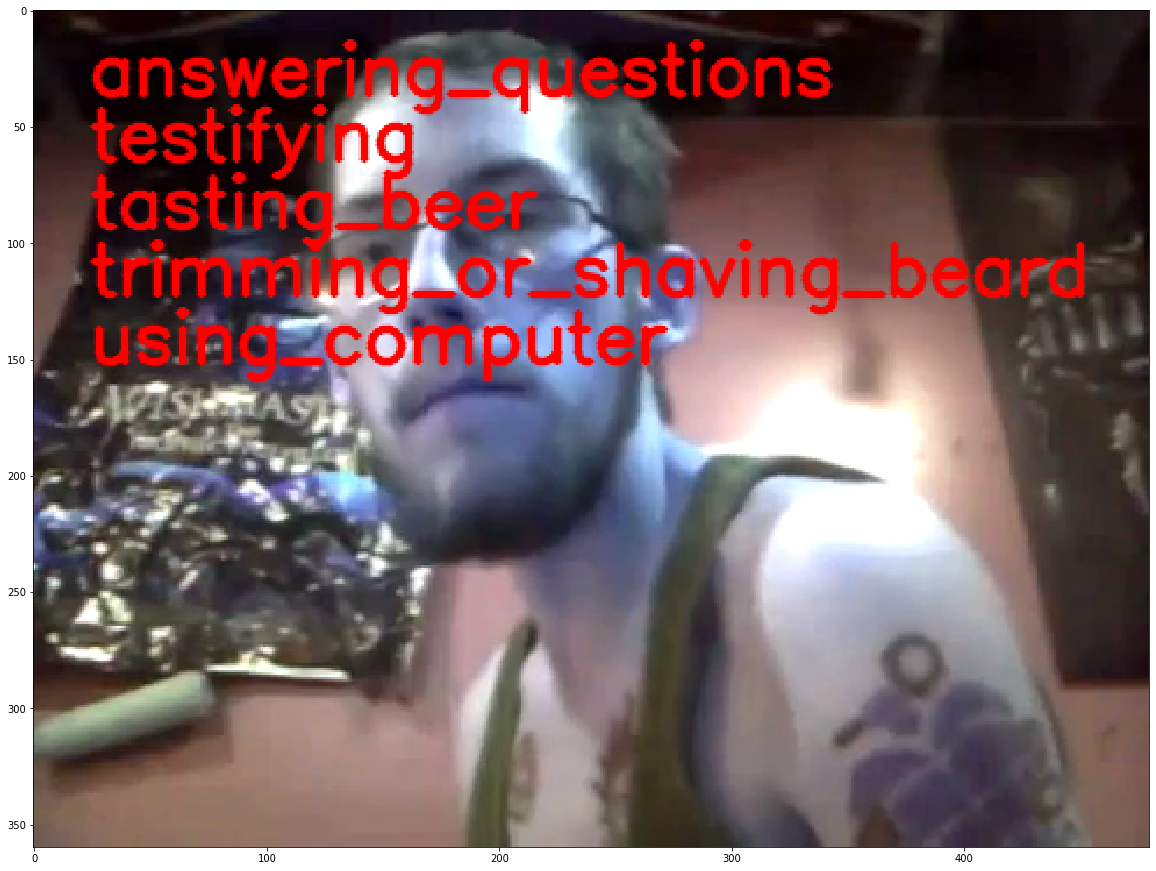

In [12]:
def main():
    ActionDetection().run()
main()

## 4. Upload Lambda and Create Lambda Function

* A lambda is already provided and ready for use in the lambda folder (zip file)
* Use this code snippet to upload and publish it to Lambda Service

### **4.1 AWS CLI credentials:**<br>

### **4.2 Create Role**

In [16]:
role_policy_document = {
    "Version": "2012-10-17",
    "Statement":[
        {
            "Effect": "Allow",
            "Principal": {"Service": ["lambda.amazonaws.com", "events.amazonaws.com"]},
            "Action": "sts:AssumeRole",
        }
    ]
}

iam_client = boto3.client("iam")

iam_client.create_role(
    RoleName="SmokingDetectionExecutionRole",
    AssumeRolePolicyDocument=json.dumps(role_policy_document),
)

{'Role': {'Path': '/',
  'RoleName': 'SmokingDetectionExecutionRole1',
  'RoleId': 'AROAZAPJMVFPMA32FIY22',
  'Arn': 'arn:aws:iam::619501627742:role/SmokingDetectionExecutionRole1',
  'CreateDate': datetime.datetime(2020, 11, 19, 20, 47, 55, tzinfo=tzlocal()),
  'AssumeRolePolicyDocument': {'Version': '2012-10-17',
   'Statement': [{'Effect': 'Allow',
     'Principal': {'Service': ['lambda.amazonaws.com',
       'events.amazonaws.com']},
     'Action': 'sts:AssumeRole'}]}},
 'ResponseMetadata': {'RequestId': '3119eb06-f716-4e61-a465-569fe3bc5beb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3119eb06-f716-4e61-a465-569fe3bc5beb',
   'content-type': 'text/xml',
   'content-length': '852',
   'date': 'Thu, 19 Nov 2020 20:47:55 GMT'},
  'RetryAttempts': 0}}

This Python snippet uses boto3 to create an IAM role named LambdaBasicExecutionSmoke with basic lambda execution permissions.

The following Python snippet will use all of the resources above to create a new AWS Lambda function called ActionDetectionLambdaDemo:

In [13]:
!zip -o  ../Lambda/SmokingDetectionLambda.zip  ../Lambda/action_detection.py ../Lambda/config.py

  adding: ../Lambda/action_detection.py (deflated 67%)
  adding: ../Lambda/config.py (deflated 63%)


In [17]:
lambda_client = boto3.client('lambda')

with open('../Lambda/SmokingDetectionLambda.zip', 'rb') as f:
    zipped_code = f.read()

role = iam_client.get_role(RoleName='SmokingDetectionExecutionRole')
response_create_function = lambda_client.create_function(
  FunctionName='SmokingDetectionLambda',
  Runtime='python3.7',
  Role=role['Role']['Arn'],
  Handler='action_detection.main',
  Code=dict(ZipFile=zipped_code),
  Timeout=120, 
  MemorySize=2048,
)


The following Python snippet will publish the Lambda Function we created above and return an ARN with a version. We can then use this version arn to go directly to the Panorama console and deploy our application.

In [24]:
# Publish Lambda
response = lambda_client.publish_version(
      FunctionName='SmokingDetectionLambda')

### 4.3  Print latest version number 

What is an ARN? : Amazon Resource Names (ARNs) uniquely identify AWS resources.

The following Python snippet will publish the Lambda Function we created above, and return an ARN with a version.

This version arn can be used to go directly to the Panorama console and deploy this application.

In [25]:
function_arn = response['FunctionArn']
function_arn_version = list(response['FunctionArn'].split(':'))[-1]
lambda_url = 'https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/' + response['FunctionName'] + '/versions/' + response['Version'] + '?tab=configuration'

printmd("**Function Arn** : **{}**".format(function_arn) , color="black")
printmd("**Function Arn Version** : **{}**".format(function_arn_version) , color="black")
printmd("**Lambda Console Link** : **{}**".format(lambda_url) , color="red")

<span style='color:black'>**Function Arn** : **arn:aws:lambda:us-east-1:619501627742:function:SmokingDetectionLambda:1**</span>

<span style='color:black'>**Function Arn Version** : **1**</span>

<span style='color:red'>**Lambda Console Link** : **https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/SmokingDetectionLambda/versions/1?tab=configuration**</span>

### 4.3 Upload Model to S3

In [30]:
def send_model_to_s3(model, bucket = 'aws-panorama-models-bucket'):
    s3 = boto3.resource('s3')
    s3.create_bucket(Bucket=bucket)
    
    key = '../../Models/' + model
    
    s3.Object(bucket, model).put(Body=open(key, 'rb'))
    
    bucket_name = bucket
    
    
    location = boto3.client('s3').get_bucket_location(Bucket='aws-panorama-models-bucket')['LocationConstraint']
    url = "s3://{}/{}".format(bucket_name, model)
    
    printmd("**S3 Path** : **{}**".format(url), color="black")
    
    return

In [31]:
send_model_to_s3(model = 'resnet101_v1b_kinetics400.tar.gz')

<span style='color:black'>**S3 Path** : **s3://aws-panorama-models-bucket/resnet101_v1b_kinetics400.tar.gz**</span>

### 4.4 Deploy the Application

Now that our Lambda is created and published, you are ready to deploy your model and the lambda function you created here, to the Panorama device

[Creating Application Instructions Here](https://alpha-docs-aws.amazon.com/omni/latest/devguide/omni-welcome.html)